In [9]:
from common import *

In [5]:
df_fingerprint_model_params = pd.read_csv("./data/filtered/apb/fingerprint_model_params.csv")
df_fingerprint_model_params

,target_mac,monitor_mac,rssi_0,n
0,20f094118214,08a6f7a1e5c8,-46.488243,2.914109
1,20f094118214,24a1602ccfab,-44.196182,2.998748
2,20f094118214,483fda467e7a,-47.123330,2.935286
3,20f094118214,a0a3b3ff35c0,-49.003914,1.870136
4,20f094118214,a0a3b3ff66b4,-57.520579,1.186322
5,20f094118214,a4cf12fdaea9,-47.399108,2.814001
6,20f094118214,d8bfc0117c7d,-55.737894,1.407107
7,20f094118214,f8b3b732fb6c,-44.573545,3.077004
8,20f094118214,f8b3b73303e8,-55.575197,2.555942
9,20f094118214,f8b3b734347c,-53.791912,1.383097


In [6]:
def prep_path_data(df):
    # Merge coordinates into single columns
    df["anchor_position"] = list(zip(df["anchor_position_x"], df["anchor_position_y"]))

    # Round the coordinates in the anchor_position and target_position columns
    df["anchor_position"] = df["anchor_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))

    # Drop the original coordinate columns if no longer needed
    df.drop(columns=["anchor_position_x", "anchor_position_y", "target_position_x", "target_position_y"], inplace=True)

    df.sort_values("timestamp", inplace=True)

    return df

In [7]:
df_path_youtube = prep_path_data(pd.read_csv("./data/filtered/apb/Pixel9_path_youtube.csv"))
df_path_youtube

,timestamp,monitor_mac,target_mac,rssi,anchor_position
0,1.734005e+09,483fda467e7a,20f094118214,-59.0,"(1461, 241)"
1,1.734005e+09,483fda467e7a,20f094118214,-60.0,"(1461, 241)"
2,1.734005e+09,a4cf12fdaea9,20f094118214,-60.0,"(861, 580)"
3,1.734005e+09,f8b3b732fb6c,20f094118214,-63.0,"(1461, 241)"
4,1.734005e+09,f8b3b732fb6c,20f094118214,-63.0,"(1461, 241)"
...,...,...,...,...,...
8707,1.734005e+09,08a6f7a1e5c8,20f094118214,-67.0,"(884, 45)"
8708,1.734005e+09,f8b3b732fb6c,20f094118214,-65.0,"(1461, 241)"
8709,1.734005e+09,08a6f7a1e5c8,20f094118214,-66.0,"(884, 45)"
8710,1.734005e+09,f8b3b734347c,20f094118214,-66.0,"(1047, 884)"


In [13]:
def prep_data(df):
    # Merge coordinates into single columns
    df["anchor_position"] = list(zip(df["anchor_position_x"], df["anchor_position_y"]))
    df["target_position"] = list(zip(df["target_position_x"], df["target_position_y"]))

    # Round the coordinates in the anchor_position and target_position columns
    df["anchor_position"] = df["anchor_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))
    df["target_position"] = df["target_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))

    # Drop the original coordinate columns if no longer needed
    df.drop(columns=["anchor_position_x", "anchor_position_y", "target_position_x", "target_position_y"], inplace=True)

    # Group by monitor_mac and target_position, and calculate the median RSSI
    df_median_rssi = (
        df.groupby(["target_position", "target_mac", "monitor_mac", "anchor_position"], as_index=False)
        .agg({"rssi": "median"})
    )

    return df_median_rssi

In [14]:
# fingerprint data
df_fingerprint_pixel9 = prep_data(pd.read_csv("./data/filtered/apb/Pixel9.csv"))
df_fingerprint_p20 = prep_data(pd.read_csv("./data/filtered/apb/P20_Pro.csv"))
df_fingerprint_iphone = prep_data(pd.read_csv("./data/filtered/apb/iPhone.csv"))

df_fingerprint_median = pd.concat([df_fingerprint_pixel9, df_fingerprint_p20, df_fingerprint_iphone]).reset_index()

In [8]:
# Custom function to calculate the median of the last 50 rows
def compute_rolling_rssi(df):
    df = df.sort_values("timestamp")  # Sort by timestamp
    df["rolling_rssi_1"] = df["rssi"].rolling(window=1, min_periods=1).median()
    df["rolling_rssi_25"] = df["rssi"].rolling(window=25, min_periods=1).median()
    df["rolling_rssi_50"] = df["rssi"].rolling(window=50, min_periods=1).median()
    df["rolling_rssi_100"] = df["rssi"].rolling(window=100, min_periods=1).median()
    return df

# Apply rolling RSSI calculation per monitor_mac
df_transformed = df_path_youtube.groupby("monitor_mac", group_keys=False).apply(compute_rolling_rssi)

# Ensure 10 rows per timestamp (one per monitor_mac)
unique_timestamps = df_path_youtube["timestamp"].unique()
unique_monitor_macs = df_path_youtube["monitor_mac"].unique()

rows = []
for timestamp in unique_timestamps:
    for monitor_mac in unique_monitor_macs:
        # Get the most recent data for this monitor_mac and timestamp
        recent_data = df_transformed[
            (df_transformed["monitor_mac"] == monitor_mac) & (df_transformed["timestamp"] <= timestamp)
        ].sort_values("timestamp", ascending=False).head(1)
        
        if not recent_data.empty:
            rows.append({
                "timestamp": timestamp,
                "monitor_mac": monitor_mac,
                "target_mac": recent_data.iloc[0]["target_mac"],
                "rssi_1": recent_data.iloc[0]["rolling_rssi_1"],
                "rssi_25": recent_data.iloc[0]["rolling_rssi_25"],
                "rssi_50": recent_data.iloc[0]["rolling_rssi_50"],
                "rssi_100": recent_data.iloc[0]["rolling_rssi_100"],
                "anchor_position": recent_data.iloc[0]["anchor_position"],
            })

# Final transformed DataFrame
df_final_all = pd.DataFrame(rows)

# Display result
df_final_all
df_final_esp8266 = filter_esp8266(df_final_all)
df_final_esp32 = filter_esp32(df_final_all)


In [12]:
class AbstractLocalization(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def localize(self, rssis):
        pass
    
    def get_relevant_anchor_stats(self, anchor_stats, rssis):
        monitor_macs_intersec = anchor_stats.keys() & rssis.keys()
        anchor_stats_intersec = [anchor_stats[monitor_mac] for monitor_mac in monitor_macs_intersec]
        rssis_intersec = [rssis[monitor_mac] for monitor_mac in monitor_macs_intersec]
        
        return monitor_macs_intersec, anchor_stats_intersec, rssis_intersec

class TrilaterationLeastSquaresLocalization(AbstractLocalization):
    def __init__(self, anchor_positions, monitor_model_params):
        super().__init__()
        
        self.anchor_positions = anchor_positions
        self.monitor_model_params = monitor_model_params
    
    def localize(self, rssis):
        relevant_monitor_macs, relevant_positions, relevant_rssis = self.get_relevant_anchor_stats(self.anchor_positions, rssis)
        relevant_distances = [inverse_path_loss_model(rssi, self.monitor_model_params[monitor_mac][0], self.monitor_model_params[monitor_mac][1]) * 100.0 for rssi, monitor_mac in zip(relevant_rssis, relevant_monitor_macs)] # m to cm

        relevant_positions = np.array(relevant_positions)
        relevant_distances = np.array(relevant_distances)
        print(relevant_positions)

        # relevant_positions = relevant_positions / 100.0
        # relevant_distances = relevant_distances / 100.0

        print("rssis:")
        print(relevant_rssis)
        print("positions:")
        print(relevant_positions)
        print("distances:")
        print(relevant_distances)
        
        # Number of known positions
        n = len(relevant_positions)
        
        # Build the A matrix and b vector
        A = []
        b = []
        
        x_n, y_n = relevant_positions[n-1]
        d_n = relevant_distances[n-1]
        for i in range(n - 1):
            x_i, y_i = relevant_positions[i]
            d_i = relevant_distances[i]
            A.append([2*(x_i - x_n), 2*(y_i - y_n)])
            b.append(x_i**2 + y_i**2 - x_n**2 - y_n**2 - d_i**2 + d_n**2)
        A = np.array(A)
        b = np.array(b)

        print("A:")
        print(A)
        print("b:")
        print(b)

        # Debug: Check condition number
        condition_number = np.linalg.cond(A.T @ A)
        print(f"Condition Number: {condition_number}")

        # Compute the least squares solution using the normal equation: x = (A^T A)^(-1) A^T b
        position, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

        print("Lstsq data:")
        print(position)
        print(residuals)
        print(rank)
        print(s)

        # position *= 100.0
        
        return {
            'position': position,
            'distances': {monitor_mac: distance for monitor_mac, distance in zip(relevant_monitor_macs, relevant_distances)}
        }

class TrilaterationWeightedCentroidLocalization(AbstractLocalization):
    def __init__(self, anchor_positions, monitor_model_params, weight_func):
        super().__init__()
        
        self.anchor_positions = anchor_positions
        self.monitor_model_params = monitor_model_params
        self.weight_func = weight_func
    
    def localize(self, rssis):
        relevant_monitor_macs, relevant_positions, relevant_rssis = self.get_relevant_anchor_stats(self.anchor_positions, rssis)        
        relevant_positions_np = np.array(relevant_positions)

        # Calculate the weights using the custom function
        weights = np.array([self.weight_func(rssi, self.monitor_model_params[monitor_mac][0], self.monitor_model_params[monitor_mac][1]) for rssi, monitor_mac in zip(relevant_rssis, relevant_monitor_macs)])
        weight_sum = np.sum(weights)

        # Normalize the weights so they sum up to 1
        normalized_weights = weights / weight_sum
        
        # Weighted sum of positions
        x = np.sum([w * pos[0] for w, pos in zip(normalized_weights, relevant_positions_np)])
        y = np.sum([w * pos[1] for w, pos in zip(normalized_weights, relevant_positions_np)])
        
        position = (x, y)
        
        return {
            'position': position
        }

class FingerprintingLocalization(AbstractLocalization):
    def __init__(self, df_fingerprints, background_size, heatmap_resolution=5.0): # every 5cm
        super().__init__()
        
        x = np.arange(0, background_size[0], heatmap_resolution)
        y = np.arange(0, background_size[1], heatmap_resolution)
        self.pos_lookup_x = np.append(x, background_size[0]) # include boundary
        self.pos_lookup_y = np.append(y, background_size[1])
        num_x = len(self.pos_lookup_x)
        num_y = len(self.pos_lookup_y)
            
        gx, gy = np.meshgrid(self.pos_lookup_x, self.pos_lookup_y)
        gx, gy = gx.flatten(), gy.flatten()
        
        def generate_interpolated_fingerprint_map(monitor_mac):
            monitor_rows = df_fingerprints[df_fingerprints['monitor_mac'] == monitor_mac]
            
            target_positions = monitor_rows['target_position'].to_list()
            (target_positions_x, target_positions_y) = zip(*target_positions)
            rssi_medians = monitor_rows['rssi'].to_list()
            
            
            # from https://github.com/jantman/python-wifi-survey-heatmap/blob/master/wifi_survey_heatmap/heatmap.py
            
            rbf = Rbf(target_positions_x, target_positions_y, rssi_medians, function='linear')
            z = rbf(gx, gy)
            z = z.reshape((num_y, num_x))
            
            return z
        
        monitor_macs = df_fingerprints['monitor_mac'].unique()
        self.interpolated_fingerprints = {monitor_mac: generate_interpolated_fingerprint_map(monitor_mac) for monitor_mac in monitor_macs}
    
    def localize(self, rssis):
        _, relevant_interpolated_fingerprints, relevant_rssis = self.get_relevant_anchor_stats(self.interpolated_fingerprints, rssis)
        
        diff = np.moveaxis(relevant_interpolated_fingerprints, 0, -1) - relevant_rssis        
        norm = np.linalg.norm(diff, axis=2)
        min_pos_heatmap = np.unravel_index(np.argmin(norm, axis=None), norm.shape)        
        min_pos = (self.pos_lookup_x[min_pos_heatmap[1]], self.pos_lookup_y[min_pos_heatmap[0]])
        
        position = min_pos
        
        return {
            'position': position,
            'heatmap': norm
        }

In [15]:
def path_positioning(df, rssi_column):
    anchor_positions = df_path_youtube.set_index('monitor_mac')['anchor_position'].to_dict()
    anchor_model_params = df_fingerprint_model_params.set_index('monitor_mac')[['rssi_0', 'n']].apply(tuple, axis=1).to_dict()

    def weight_rssi_9(rssi, rssi_0, n):
        return pow(abs(rssi), -9.0) # try different exponents → 9 worked best

    twcl_rssi_9 = TrilaterationWeightedCentroidLocalization(anchor_positions, anchor_model_params, weight_rssi_9)
    df_fingerprints_target_mac = df_fingerprint_median[df_fingerprint_median["target_mac"] == df_path_youtube["target_mac"].unique().item()]
    print(df_fingerprints_target_mac)

    fpl = FingerprintingLocalization(df_fingerprints_target_mac, (2152, 1485)) # TODO: replace with real size

    timestamps = []
    estimations_twcl_rssi_9 = []
    estimations_fpl = []

    for timestamp in df['timestamp'].unique():
        group = df[df['timestamp'] == timestamp]
        anchor_rssis = group.set_index('monitor_mac')[rssi_column].to_dict()

        estimation_twcl_rssi_9 = tuple(twcl_rssi_9.localize(anchor_rssis)['position'])
        estimation_fpl = tuple(fpl.localize(anchor_rssis)['position'])

        timestamps.append(timestamp)
        estimations_twcl_rssi_9.append(estimation_twcl_rssi_9)
        estimations_fpl.append(estimation_fpl)
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'estimation_twcl_rssi_9': estimations_twcl_rssi_9,
        'estimation_fpl': estimations_fpl
    })

In [16]:
df_path_estimations_esp8266 = [path_positioning(df_final_esp8266, column) for column in ['rssi_1', 'rssi_25', 'rssi_50', 'rssi_100']]
df_path_estimations_esp32 = [path_positioning(df_final_esp32, column) for column in ['rssi_1', 'rssi_25', 'rssi_50', 'rssi_100']]
df_path_estimations_all = [path_positioning(df_final_all, column) for column in ['rssi_1', 'rssi_25', 'rssi_50', 'rssi_100']]
df_path_estimations_all

     index target_position    target_mac   monitor_mac anchor_position  rssi
0        0       (79, 789)  20f094118214  08a6f7a1e5c8       (884, 45) -80.0
1        1       (79, 789)  20f094118214  24a1602ccfab     (2048, 884) -35.5
2        2       (79, 789)  20f094118214  483fda467e7a     (1461, 241) -82.0
3        3       (79, 789)  20f094118214  a0a3b3ff35c0     (2048, 884) -58.0
4        4       (79, 789)  20f094118214  a0a3b3ff66b4      (107, 884) -58.5
..     ...             ...           ...           ...             ...   ...
204    204     (2080, 783)  20f094118214  a4cf12fdaea9      (861, 580) -82.0
205    205     (2080, 783)  20f094118214  d8bfc0117c7d      (107, 884) -61.0
206    206     (2080, 783)  20f094118214  f8b3b732fb6c     (1461, 241) -80.0
207    207     (2080, 783)  20f094118214  f8b3b73303e8      (861, 580) -84.0
208    208     (2080, 783)  20f094118214  f8b3b734347c     (1047, 884) -65.0

[209 rows x 6 columns]
     index target_position    target_mac   monitor_m

[         timestamp                   estimation_twcl_rssi_9   estimation_fpl
 0     1.734005e+09                          (1461.0, 241.0)  (1035.0, 450.0)
 1     1.734005e+09                          (1461.0, 241.0)  (1510.0, 380.0)
 2     1.734005e+09                          (1161.0, 410.5)  (1435.0, 480.0)
 3     1.734005e+09  (1234.1233543377393, 369.1853047991771)  (1415.0, 520.0)
 4     1.734005e+09  (1234.1233543377393, 369.1853047991771)  (1415.0, 520.0)
 ...            ...                                      ...              ...
 8583  1.734005e+09  (1199.9025871968488, 453.5615442434104)  (1445.0, 445.0)
 8584  1.734005e+09  (1202.2008251250154, 451.6905299051022)  (1445.0, 435.0)
 8585  1.734005e+09   (1199.811894148779, 448.6372518243476)  (1435.0, 445.0)
 8586  1.734005e+09  (1198.6731894318568, 451.8814339456493)  (1435.0, 445.0)
 8587  1.734005e+09   (1195.968101107242, 448.3836773733265)  (1430.0, 450.0)
 
 [8588 rows x 3 columns],
          timestamp                 

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap

def plot_paths(position_lists, algorithm_labels, alphas, background_image_path):
    """
    Plots the target position and estimated positions from multiple algorithms for multiple target devices
    across three hardware configurations.
    
    Parameters:
        df1, df2, df3 (pandas.DataFrame): DataFrames containing localization data for different hardware configurations.
        background_image_filepath (str): Filepath to the background image for plotting.
    """
    # Load the background image
    if background_image_path:
        img = plt.imread(background_image_path)
        # ax.imshow(img, aspect='auto', alpha=0.5)

    plt.imshow(img, aspect='auto', alpha=0.5)

    for idx, position_list in enumerate(position_lists):
        x_values, y_values = zip(*position_list)

        # Plot the points
        plt.plot(x_values, y_values, linestyle='-', alpha=alphas[idx], label=algorithm_labels[idx])
            
    # Set axis labels and title
    plt.title(f'Path', fontsize=14)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [18]:
# Function to reduce each set of tuples
def reduce_coordinates(df, N):
    # Split the tuple columns into x and y
    twcl_rssi_x, twcl_rssi_y = zip(*df['estimation_twcl_rssi_9'])
    fpl_x, fpl_y = zip(*df['estimation_fpl'])
    
    # Create new DataFrame columns with the x and y values for both sets
    df['twcl_rssi_x'] = twcl_rssi_x
    df['twcl_rssi_y'] = twcl_rssi_y
    df['fpl_x'] = fpl_x
    df['fpl_y'] = fpl_y
    
    # Group by N rows and compute the mean for each set of coordinates
    reduced_df = df.groupby(df.index // N).agg({
        'twcl_rssi_x': 'mean', 'twcl_rssi_y': 'mean',
        'fpl_x': 'mean', 'fpl_y': 'mean'
    }).reset_index(drop=True)
    
    # Combine the x and y values back into tuples
    reduced_df['estimation_twcl_rssi_9'] = list(zip(reduced_df['twcl_rssi_x'], reduced_df['twcl_rssi_y']))
    reduced_df['estimation_fpl'] = list(zip(reduced_df['fpl_x'], reduced_df['fpl_y']))
    
    # Drop the intermediate x and y columns
    reduced_df = reduced_df.drop(columns=['twcl_rssi_x', 'twcl_rssi_y', 'fpl_x', 'fpl_y'])
    
    return reduced_df

# Apply the reduction (mean of every 3 rows)
df_path_estimations_reduced_esp8266 = [reduce_coordinates(df_path_estimation, 1) for df_path_estimation in df_path_estimations_esp8266]
df_path_estimations_reduced_esp32 = [reduce_coordinates(df_path_estimation, 1) for df_path_estimation in df_path_estimations_esp32]
df_path_estimations_reduced_all = [reduce_coordinates(df_path_estimation, 1) for df_path_estimation in df_path_estimations_all]

ESP8266:


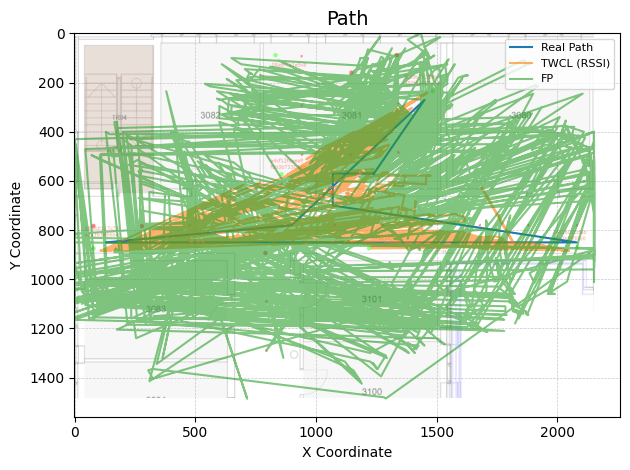

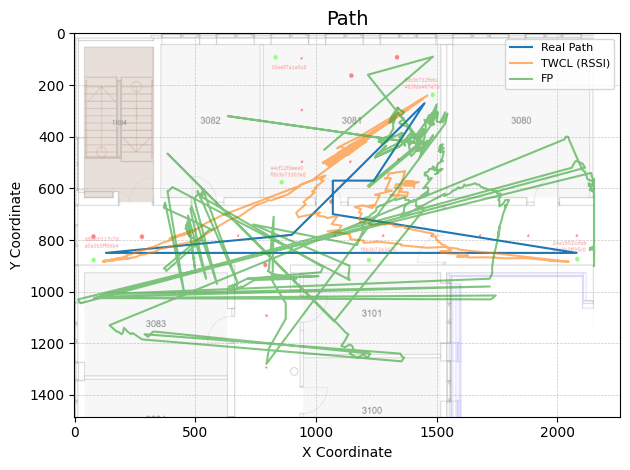

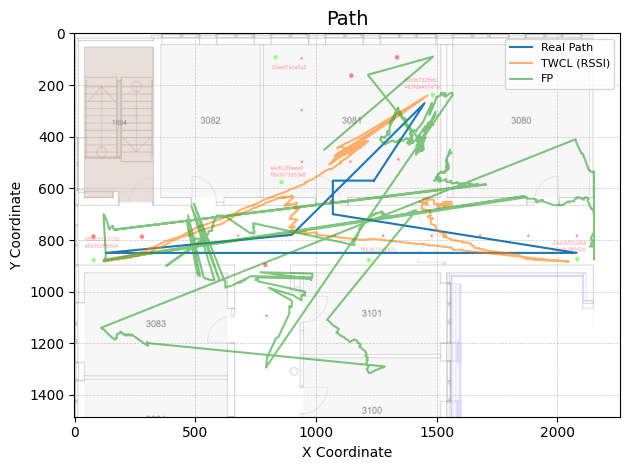

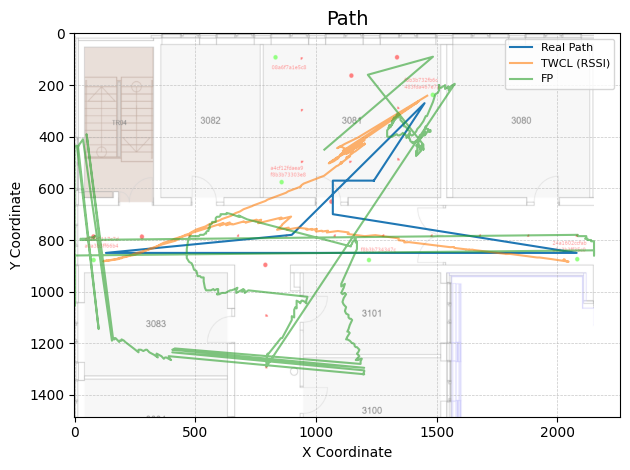

ESP32:


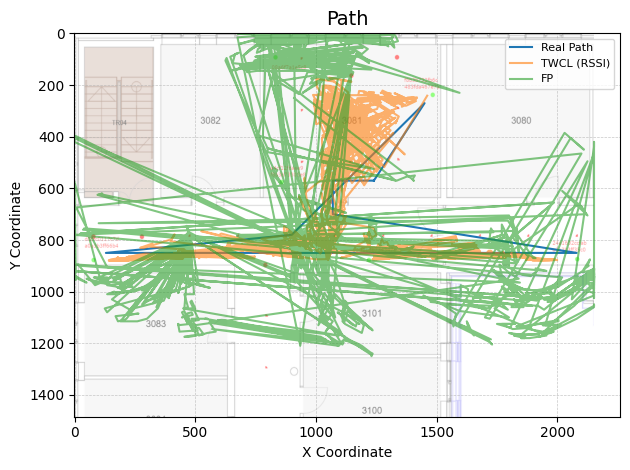

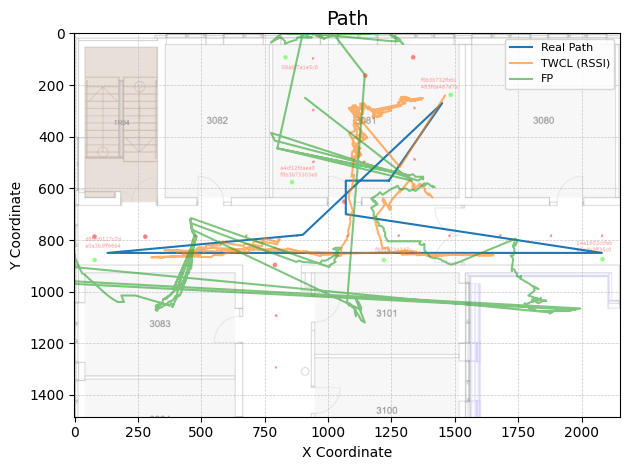

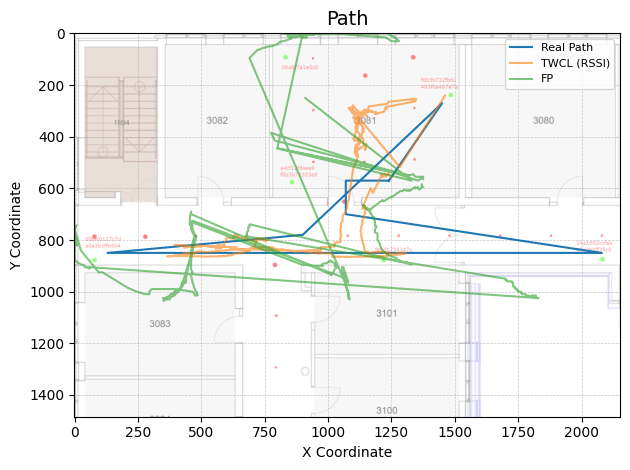

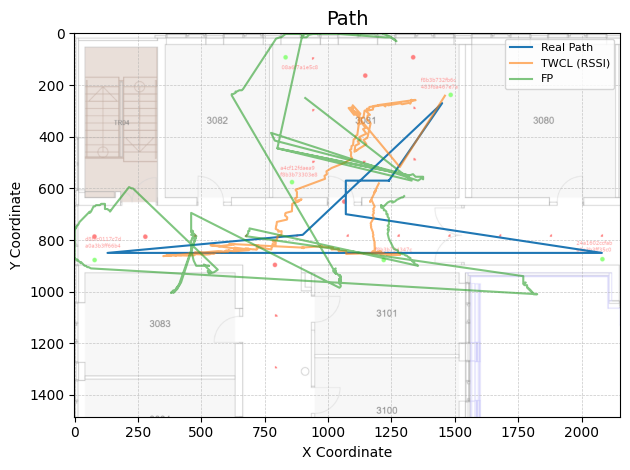

All:


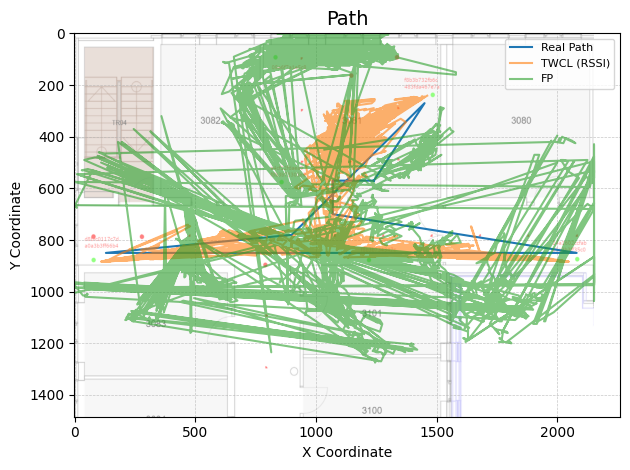

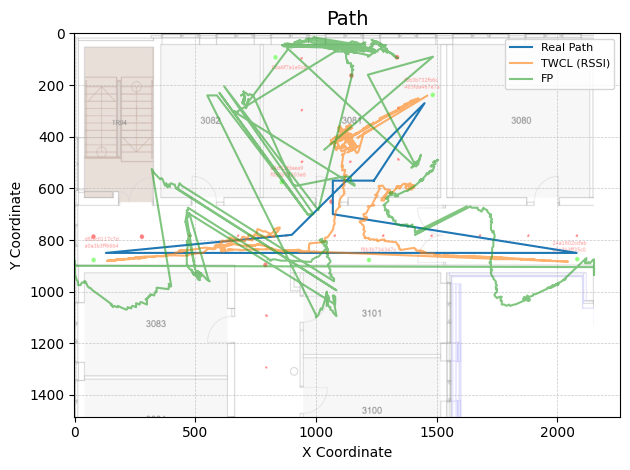

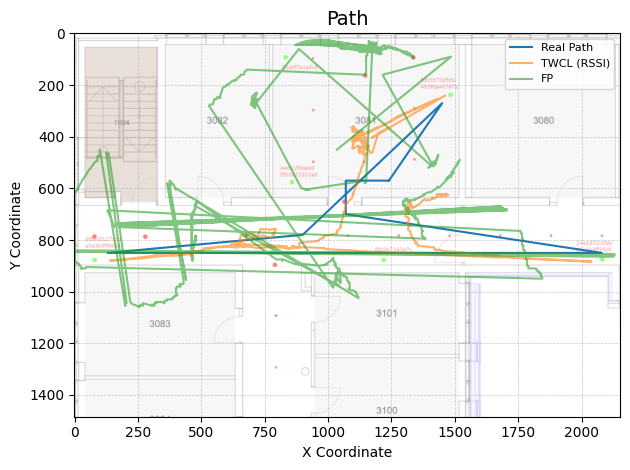

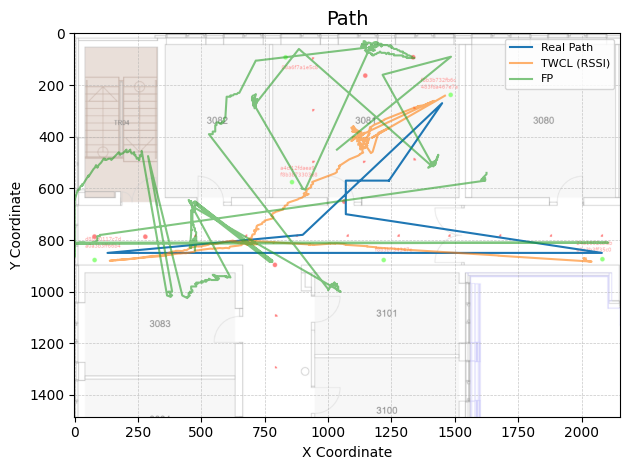

[None, None, None, None]

In [19]:
real_path = [
    (1240, 570),
    (1450, 270),
    (900, 780),
    (130, 850),
    (2080, 850),
    (1070, 700),
    (1070, 570),
    (1240, 570)
]

print('ESP8266:')
[plot_paths([real_path, df_reduced['estimation_twcl_rssi_9'].to_list(), df_reduced['estimation_fpl'].to_list()], ['Real Path', 'TWCL (RSSI)', 'FP'], [1.0, 0.6, 0.6], './images/apb_3081_scaled_fingerprints.png') for df_reduced in df_path_estimations_reduced_esp8266]
print('ESP32:')
[plot_paths([real_path, df_reduced['estimation_twcl_rssi_9'].to_list(), df_reduced['estimation_fpl'].to_list()], ['Real Path', 'TWCL (RSSI)', 'FP'], [1.0, 0.6, 0.6], './images/apb_3081_scaled_fingerprints.png') for df_reduced in df_path_estimations_reduced_esp32]
print('All:')
[plot_paths([real_path, df_reduced['estimation_twcl_rssi_9'].to_list(), df_reduced['estimation_fpl'].to_list()], ['Real Path', 'TWCL (RSSI)', 'FP'], [1.0, 0.6, 0.6], './images/apb_3081_scaled_fingerprints.png') for df_reduced in df_path_estimations_reduced_all]